### **Title: Movie Genre Classification**

### **Objective**: <font size="3">Create a machine learning model that can predict the genre of a movie based on its plot summary or other textual information.</font>


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries for data manipulation and analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

### **Training Data**

In [ ]:
# Load the training data

train_path = '/content/drive/MyDrive/Codsoft_projects/Movie_Genre_Classification/Genre Classification Dataset/train_data.txt'
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

### Basic Checks

In [ ]:
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [ ]:
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [ ]:
# Checking for missing data
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

- No null data is present

### **Test Data**

In [ ]:
# Load the test data

test_path = '/content/drive/MyDrive/Codsoft_projects/Movie_Genre_Classification/Genre Classification Dataset/test_data.txt'
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')

In [ ]:
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


### **Exploratory Data Analysis (EDA)**

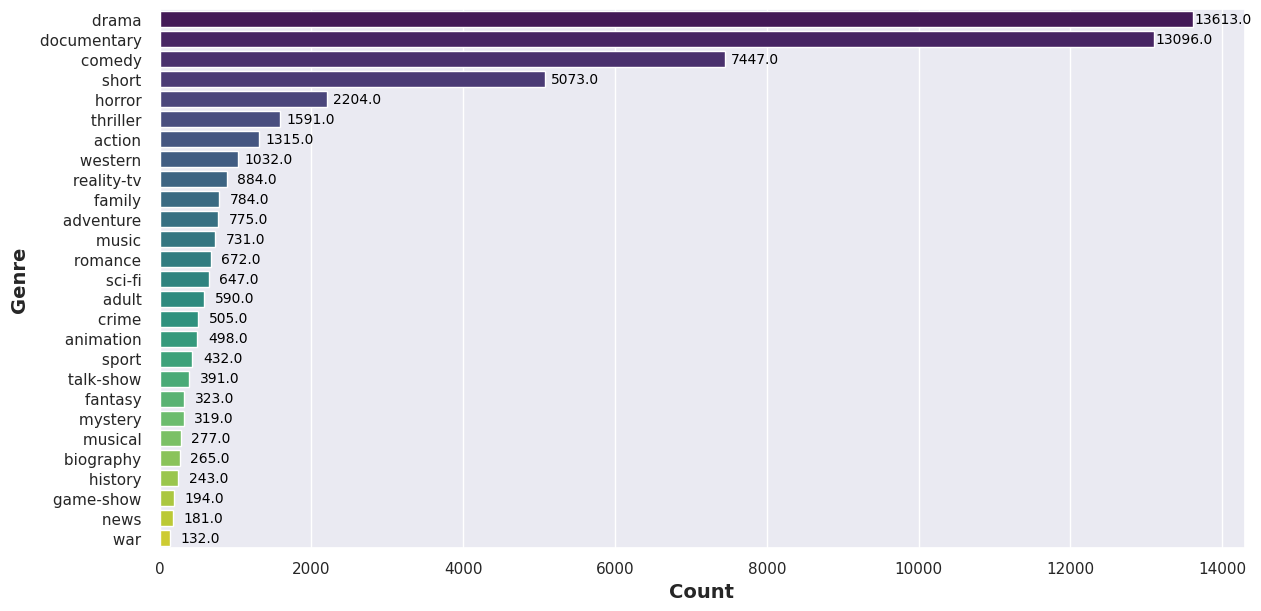

In [ ]:
# Plot for distribution of genres in the training data

plt.figure(figsize=(14, 7))
sns.set(style="darkgrid")
ax = sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')
for p in ax.patches:
  ax.annotate(f'{p.get_width()}', (p.get_width() + 400, p.get_y() + p.get_height() / 2), ha='center', va='center', fontsize=10, color='black')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')
plt.show()

- The dataset includes different genres of movies.
- The genre "Drama" has the highest frequency of 13,613 indicating a significant number of movies belonging to this genre, followed by comedy and documentary.
- The least popular genres are war, news, and biography.


### **Data Preprocessing**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Initialize the stemmer and stop words
ps = PorterStemmer() #for word stemming
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Removes user mentions from the text
    text = re.sub(r'http\S+', '', text)  # Removes URLs
    text = re.sub(r'pic.\S+', '', text) # Removes image URLs
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keeps only alphabetic characters and apostrophes, discarding non-alphabetic characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keeps words with length > 1
    text = "".join([i for i in text if i not in string.punctuation]) # Removes Punctuations
    words = nltk.word_tokenize(text) # Tokenizes the text into words
    stop_words = set(stopwords.words('english'))  # Removes stopwords

    # Additional code for stemming and stopwords removal
    ps = PorterStemmer()
    text = [ps.stem(word) for word in words if word not in stop_words and len(word) > 2]
    text = ' '.join(text)

    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated, leading & trailing spaces
    return text


In [ ]:
# Apply the clean_text function to the 'Description' column for the training and test data

train_data['Cleaned_text'] = train_data['Description'].apply(clean_text)
test_data['Cleaned_text'] = test_data['Description'].apply(clean_text)

In [ ]:
# Calculate the length of cleaned text
train_data['length_Cleaned_text'] = train_data['Cleaned_text'].apply(len)
train_data['length_Cleaned_text']

1        339
2        111
3        344
4        678
5        347
        ... 
54210    308
54211    466
54212    103
54213    362
54214    190
Name: length_Cleaned_text, Length: 54214, dtype: int64

In [ ]:
train_data

,Title,Genre,Description,Cleaned_text,length_Cleaned_text
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listen convers doctor parent year old oscar le...,339
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestu relationship curre...,111
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bu empti student field trip museum natur histo...,344
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemploy father make end meet edith twin ...,678
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film titl refer recov bodi ground zero also st...,347
...,...,...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...,short live nbc live sitcom center bonino world...,308
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...,next gener exploit sister kapa bay soror hous ...,466
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g...",bestaan echt stand comedi grow face fear freer...,103
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,walter vivian live countri difficult time keep...,362


In [ ]:
test_data

,Id,Title,Description,Cleaned_text
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane love life car apart job especi girlfrien...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughti child three belong w...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin famili shepherd north tran...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father die hasnt spoken brother year seriou ca...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known intern martial art superstar bruce lee a...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da...",cover multipl genr tale light dark antholog we...
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...,alic cora munro attempt find father british of...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...,movi year make oliv twist art dodger fagin lov...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard...",popular mysteri rock mike mallard askew broadc...


### **Text Vectorization**
- Text vectorization is performed using TF-IDF (Term Frequency- Inverse Document Frequency)

In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Cleaned_text'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Cleaned_text'])


### **Model Training**

In [ ]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### **Naive Bayes**

In [ ]:
# Initialize and train Naive Bayes Model
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

In [ ]:
NB_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [ ]:
# Make predictions on the validation set
y_pred = NB_classifier.predict(X_val)

In [ ]:
# Evaluate the performance of the model

accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\n")
print(classification_report(y_val, y_pred,zero_division=1))

Validation Accuracy: 0.4407451812229088


               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.64      0.04      0.08      1443
       crime        0.00      0.00      0.00       107
 documentary        0.52      0.89      0.66      2659
       drama        0.38      0.87      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on test data

X_test_predictions = NB_classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [ ]:
# Display the 'test_data' DataFrame with predicted genres
print(test_data)

          Id                             Title  \
0          1             Edgar's Lunch (1998)    
1          2         La guerra de papá (1977)    
2          3      Off the Beaten Track (2010)    
3          4           Meu Amigo Hindu (2015)    
4          5                Er nu zhai (1955)    
...      ...                               ...   
54195  54196   "Tales of Light & Dark" (2013)    
54196  54197      Der letzte Mohikaner (1965)    
54197  54198              Oliver Twink (2007)    
54198  54199                Slipstream (1973)    
54199  54200        Curitiba Zero Grau (2010)    

                                             Description  \
0       L.R. Brane loves his life - his car, his apar...   
1       Spain, March 1964: Quico is a very naughty ch...   
2       One year in the life of Albin and his family ...   
3       His father has died, he hasn't spoken with hi...   
4       Before he was known internationally as a mart...   
...                                    

In [ ]:
logreg = LogisticRegression(max_iter=1000)

In [ ]:
# Train the model on the training data
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
# Make predictions on the validation set
y_pred = logreg.predict(X_val)

In [ ]:
# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\n")
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.5833256478834271


               precision    recall  f1-score   support

      action        0.58      0.28      0.38       263
       adult        0.83      0.26      0.39       112
   adventure        0.39      0.12      0.19       139
   animation        0.57      0.04      0.07       104
   biography        0.00      0.00      0.00        61
      comedy        0.52      0.59      0.56      1443
       crime        0.33      0.02      0.04       107
 documentary        0.66      0.85      0.75      2659
       drama        0.53      0.80      0.64      2697
      family        0.50      0.07      0.13       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.94      0.40      0.56        40
     history        0.00      0.00      0.00        45
      horror        0.66      0.58      0.62       431
       music        0.68      0.44      0.53       144
     musical        0.00      0.00      0.00        50
     mystery        0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on test data

X_test_predictions_log_reg = logreg.predict(X_test)

In [ ]:
test_data['Predicted_Genre_log_reg'] = X_test_predictions

In [ ]:
test_data

,Id,Title,Description,Cleaned_text,Predicted_Genre,Predicted_Genre_log_reg
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane love life car apart job especi girlfrien...,drama,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughti child three belong w...,drama,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin famili shepherd north tran...,documentary,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father die hasnt spoken brother year seriou ca...,drama,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known intern martial art superstar bruce lee a...,drama,drama
...,...,...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da...",cover multipl genr tale light dark antholog we...,drama,drama
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...,alic cora munro attempt find father british of...,drama,drama
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...,movi year make oliv twist art dodger fagin lov...,drama,drama
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard...",popular mysteri rock mike mallard askew broadc...,drama,drama


### **Hyperparameter Tuning**

In [ ]:
best_accuracy = 0.0
alpha_val = 0.0

for i in np.arange(0.1, 0.5, 0.1):
    temp_classifier = MultinomialNB(alpha=i)
    temp_classifier.fit(X_train, y_train)
    temp_y_pred = temp_classifier.predict(X_val)
    score = accuracy_score(y_val, temp_y_pred)

    print("Accuracy score for alpha={} is: {}%".format(round(i, 1), round(score * 100, 2)))

    if score > best_accuracy:
        best_accuracy = score
        alpha_val = i

print("\nBest accuracy is {}% with alpha value as {}".format(round(best_accuracy * 100, 2), round(alpha_val, 1)))


Accuracy score for alpha=0.1 is: 50.24%
Accuracy score for alpha=0.2 is: 47.75%
Accuracy score for alpha=0.3 is: 46.34%
Accuracy score for alpha=0.4 is: 45.57%

Best accuracy is 50.24% with alpha value as 0.1


- The accuracy scores ranged from 45.57% to 50.24% across different alpha values.
- The highest accuracy of 50.24% was achieved with an alpha value of 0.1.

In [ ]:
best_accuracy = 0.0
best_C = 0.0

for i in np.arange(0.1, 0.5, 0.1):
    temp_classifier = LogisticRegression(C=1/i,max_iter=1000)  # Inverse of regularization strength
    temp_classifier.fit(X_train, y_train)
    temp_y_pred = temp_classifier.predict(X_val)
    score = accuracy_score(y_val, temp_y_pred)

    print("Accuracy score for C={} is: {}%".format(round(1/i, 4), round(score * 100, 2)))

    if score > best_accuracy:
        best_accuracy = score
        best_C = 1/i

print("\nBest accuracy is {}% with C value as {}".format(round(best_accuracy * 100, 2), round(best_C, 4)))


Accuracy score for C=10.0 is: 57.69%
Accuracy score for C=5.0 is: 58.38%
Accuracy score for C=3.3333 is: 58.54%
Accuracy score for C=2.5 is: 58.65%

Best accuracy is 58.65% with C value as 2.5


In [ ]:
# Make predictions on test data
hyper_predictions = temp_classifier.predict(X_test)

[' comedy ' ' drama ' ' documentary ' ... ' comedy ' ' drama ' ' short ']


- No difference in scores even after hyperpaarmeter tuning.